## Gassmann equation and AVO 

#### Reproduce the figures 5 and 8 from [Smith et al. (2003)](https://library.seg.org/doi/10.1190/1.1567211) - Gassmann fluid substitutions: A tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import impedance as ip
import avo_func as avo
from IPython.display import Image
%matplotlib inline

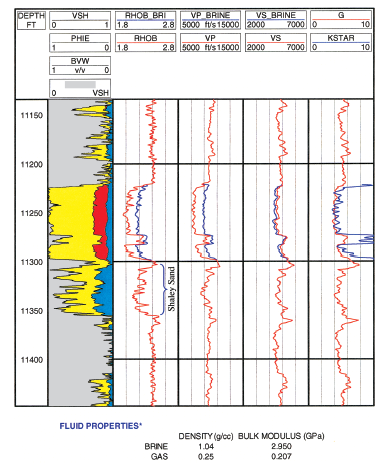

In [2]:
Image(filename='fig5_smith_2003_gassmann.png', width=400)

In [3]:
#vp, vs, rho - from figure 7, the velocities were converted to m/s
shale = [3030,1491,2.41]
sandgas = [2489,1462,2.08]

#### The properties will generate the logs

In [4]:
vp1 = np.zeros(100) + shale[0] 
vs1 = np.zeros(100) + shale[1]
rho1 = np.zeros(100) + shale[2] 
vp2 = np.zeros(100) + sandgas[0]
vs2 = np.zeros(100) + sandgas[1] 
rho2 = np.zeros(100) + sandgas[2] 

vp=np.concatenate((vp1,vp2,vp1))
vs=np.concatenate((vs1,vs2,vs1))
rho=np.concatenate((rho1,rho2,rho1))

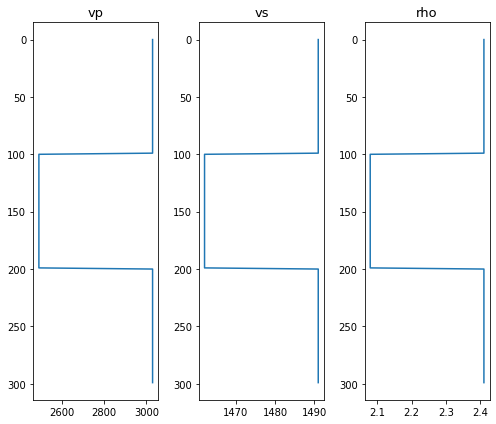

In [5]:
fig=plt.figure(figsize=(7,6))

ax=plt.subplot(1,3,1)
plt.title('vp',fontsize=13)
plt.plot(vp,np.arange(vp.shape[0]))
ax.invert_yaxis()

ax=plt.subplot(1,3,2)
plt.title('vs',fontsize=13)
plt.plot(vs,np.arange(vs.shape[0]))
ax.invert_yaxis()

ax=plt.subplot(1,3,3)
plt.title('rho',fontsize=13)
plt.plot(rho,np.arange(rho.shape[0]))
ax.invert_yaxis()

plt.tight_layout()

pre-Gassmann

In [6]:
vp_in=sandgas[0]/1000 #vel to km/s
vs_in=sandgas[1]/1000 #vel to km/s
rho_in=sandgas[2]

phi=0.25 #assumed looking at figure 8
#gas density & bulk modulus - from figure 5
rho_f1, k_f1=0.25,0.207
#brine density & bulk modulus - from figure 5
rho_f2, k_f2=1.04,2.95
k0=37 # from table 1 - assuming that is quartz

Gassmann - steps from Avseth et. al (2010)

In [7]:
# step1 
k_sat1=rho_in*(vp_in**2-(4/3)*vs_in**2)
mu1=rho_in*vs_in**2
#step2 - equation 12 for kdry (Smith et al., 2003) and eq 1 for the new k_sat2 
kdry= (k_sat1 * ((phi*k0)/k_f1+1-phi)-k0) / ((phi*k0)/k_f1+(k_sat1/k0)-1-phi)
k_sat2 = kdry + (1- (kdry/k0))**2 / ( (phi/k_f2) + ((1-phi)/k0) - (kdry/k0**2) )
#step 3 - mu1=mu2
mu2=mu1
#step4 - new density
rho_out=rho_in+phi*(rho_f2-rho_f1)
#step 5 - new velocities
vp_out=np.sqrt((k_sat2+(4/3)*mu2)/rho_out)*1000 #to km
vs_out=np.sqrt(mu2/rho_out)*1000 #to km

#### The properties will generate the logs

In [8]:
vp1 = np.zeros(100) + shale[0] 
vs1 = np.zeros(100) + shale[1]
rho1 = np.zeros(100) + shale[2] 
vp2 = np.zeros(100) + vp_out
vs2 = np.zeros(100) + vs_out
rho2 = np.zeros(100) + rho_out 

vp2=np.concatenate((vp1,vp2,vp1))
vs2=np.concatenate((vs1,vs2,vs1))
rho2=np.concatenate((rho1,rho2,rho1))

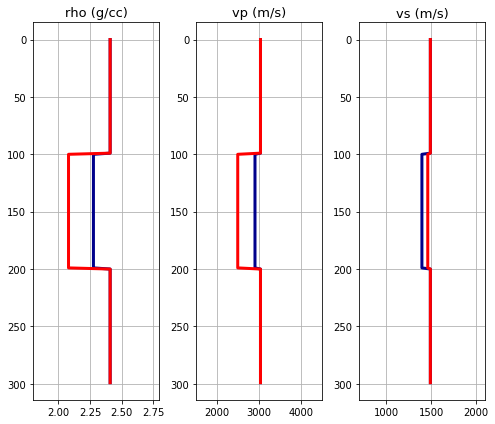

In [9]:
fig=plt.figure(figsize=(7,6))

ax=plt.subplot(1,3,1)
plt.title('rho (g/cc)',fontsize=13)
plt.plot(rho2,np.arange(rho.shape[0]),color='darkblue',linewidth=3)
plt.plot(rho,np.arange(rho.shape[0]),color='red',linewidth=3)
ax.set_xlim(1.8,2.8)
ax.invert_yaxis()
plt.grid()

ax=plt.subplot(1,3,2)
plt.title('vp (m/s)',fontsize=13)
plt.plot(vp2,np.arange(vp.shape[0]),color='darkblue',linewidth=3)
plt.plot(vp,np.arange(vp.shape[0]),color='red',linewidth=3)
ax.set_xlim(1500,4500)
ax.invert_yaxis()
plt.grid()

ax=plt.subplot(1,3,3)
plt.title('vs (m/s)',fontsize=13)
plt.plot(vs2,np.arange(vs.shape[0]),color='darkblue',linewidth=3)
plt.plot(vs,np.arange(vs.shape[0]),color='red',linewidth=3)
ax.set_xlim(700,2100)
ax.invert_yaxis()
plt.grid()

plt.tight_layout()

### References:

Avseth, P., Mukerji, T., & Mavko, G., 2010. Quantitative seismic interpretation: Applying rock physics tools to reduce interpretation risk. Cambridge university press.

Tad M. Smith, Carl H. Sondergeld, and Chandra S. Rai, (2003), "Gassmann fluid substitutions: A tutorial," GEOPHYSICS 68: 430-440. 

